# Sentiment Based Product Recommendation System

You are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

**1. Data sourcing and sentiment analysis** -  You have to analyse product reviews after some text preprocessing steps and build an ML model to get the sentiments corresponding to the users' reviews and ratings for multiple products.

**2. Building a recommendation system** - Use the following types of recommendation systems.

  1. User-based recommendation system
  2. Item-based recommendation system
  
Once you get the best-suited recommendation system, the next task is to recommend 20 products that a user is most likely to purchase based on the ratings. You can use the 'reviews_username' (one of the columns in the dataset) to identify your user.

**3. Improving the recommendations using the sentiment analysis model** - Link this recommendation system with the sentiment analysis model that was built earlier (recall that we asked you to select one ML model out of the four options). Once you recommend 20 products to a particular user using the recommendation engine, you need to filter out the 5 best products based on the sentiments of the 20 recommended product reviews.

**4. Deploying the end-to-end project with a user interface** - Once you get the ML model and the best-suited recommendation system, you will deploy the end-to-end project. You need to use the Flask framework, which is majorly used to create web applications to deploy machine learning models.

To make the web application public, you need to use Heroku, which works as the platform as a service (PaaS) that helps developers build, run and operate applications entirely on the cloud.

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import pickle
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

In [6]:
from sklearn.metrics.pairwise import pairwise_distances

In [7]:
def save_model(mdl, filename):
    filename = folderpath+"pickle/"+filename+'.pkl'
    pickle.dump(mdl, open(filename, 'wb'))

Read the data from drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
folderpath = '/content/drive/MyDrive/Upgrad_CapstoneProject/'
filepath = folderpath + 'sample30.csv'

In [10]:
prod_reviews = pd.read_csv(filepath)

### Exploratory Data Analysis

In [11]:
prod_reviews.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


In [12]:
prod_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

<Axes: xlabel='reviews_rating', ylabel='count'>

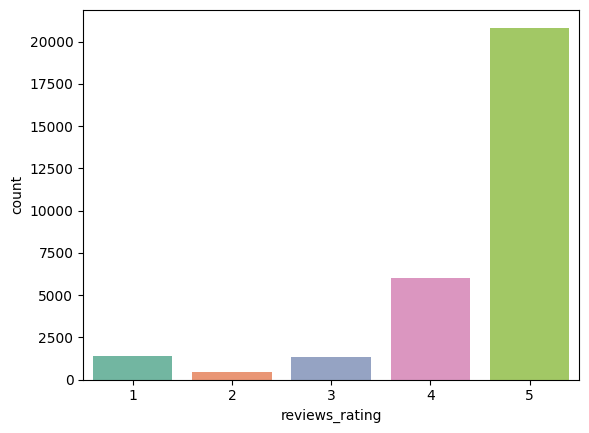

In [13]:
sns.countplot(x='reviews_rating', data=prod_reviews, palette='Set2')

From info, it is seen that there is only one row, where `user_sentiment` is null, let's exclude that row.

In [14]:
prod_reviews = prod_reviews[~prod_reviews['user_sentiment'].isnull()]

<Axes: xlabel='user_sentiment', ylabel='count'>

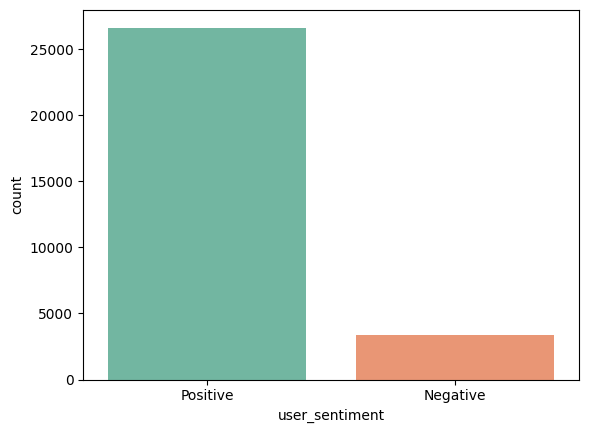

In [15]:
sns.countplot(x='user_sentiment', data=prod_reviews, palette='Set2')

This shows the Data has Class imbalance problem, this might require to be treated before building the model.

In [16]:
null_cnt = prod_reviews.isnull().sum()
null_perc = prod_reviews.isnull().sum()/prod_reviews.shape[0] * 100

In [17]:
temp = pd.concat([null_cnt, null_perc], axis=1)
temp.columns = ['null_cnt', 'null_perc']
temp.sort_values(by='null_cnt', ascending=False)

,null_cnt,null_perc
reviews_userProvince,29830,99.436648
reviews_userCity,28070,93.569786
reviews_didPurchase,14067,46.891563
reviews_doRecommend,2570,8.566952
reviews_title,190,0.633354
manufacturer,141,0.470016
reviews_username,63,0.210007
reviews_date,46,0.153338
id,0,0.000000
brand,0,0.000000


There are columns having high number of null-values, viz. reviews_userCity, reviews_userProvince, reviews_didPurchase. These won't be useful for analysis. We will drop these columns in Data Cleaning part.

Using a word cloud find the top 40 words by frequency among all the reviews_text values

In [18]:
from wordcloud import WordCloud ,STOPWORDS
stopwords = set(STOPWORDS)

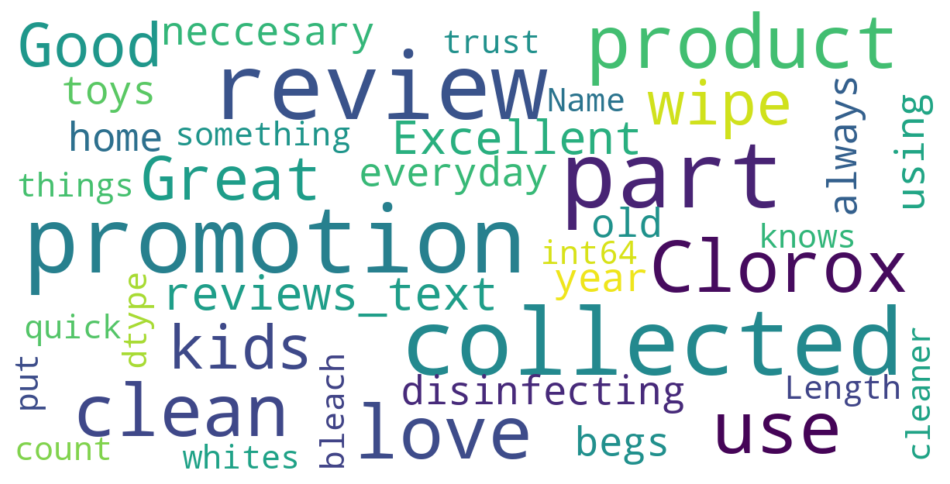

In [19]:
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(prod_reviews['reviews_text'].value_counts()))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Distribution of Reviews text length')

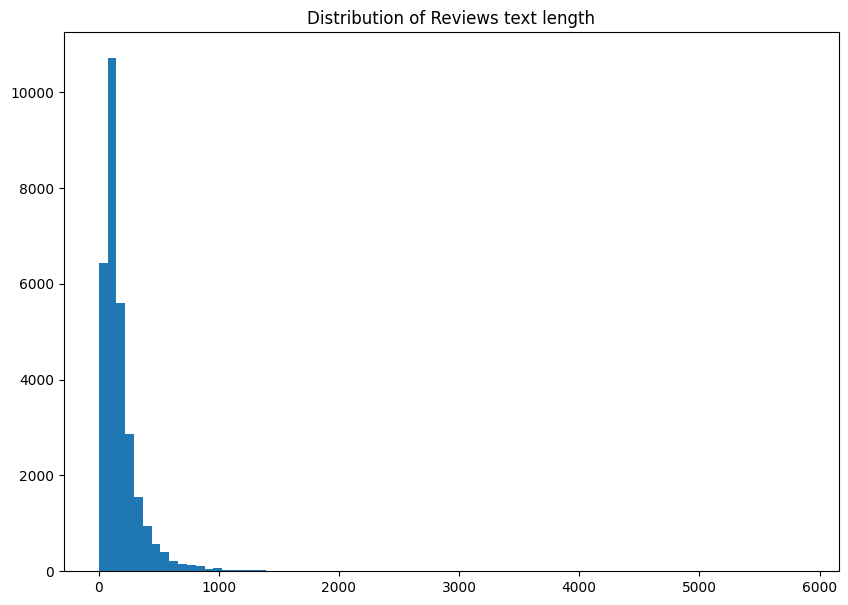

In [20]:
plt.figure(figsize=(10,7))
reviews_len = [len(d) for d in prod_reviews.reviews_text]
plt.hist(reviews_len, bins = 80)
plt.title("Distribution of Reviews text length")

The distribution is a bit skewed to the right but it is a normal distribution.

Let's visualize the Date column for data type and then observe for patterns, if any.

In [21]:

prod_reviews.reviews_date.dtype

dtype('O')

In [22]:
# converting the column to date type
prod_reviews.reviews_date = pd.to_datetime(prod_reviews.reviews_date, errors='coerce')

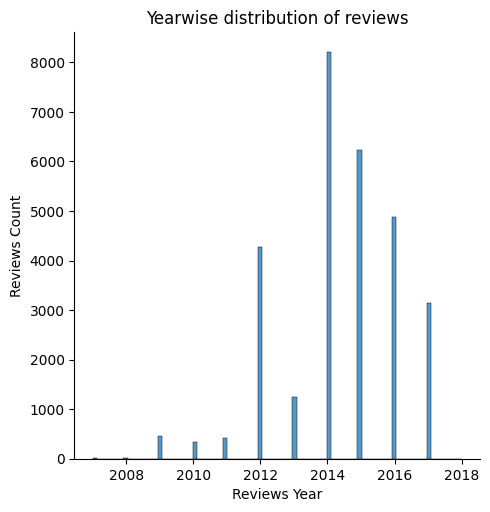

In [23]:
sns.displot(prod_reviews.reviews_date.dt.year).set(title='Yearwise distribution of reviews', xlabel='Reviews Year', ylabel='Reviews Count')

There is nothing significant that can be inferred from this plot. It seems that `reviews_date` is not impacting and can be removed.

Let's analyse `reviews_doRecommend` column. This column indicates whether a particular user has recommended the product or not.

In [24]:
prod_reviews.reviews_doRecommend.isnull().sum()

np.int64(2570)

In [25]:
prod_reviews.reviews_doRecommend.value_counts(normalize=True)

,proportion
reviews_doRecommend,
True,0.94349
False,0.05651


Let's visualize this distribution.

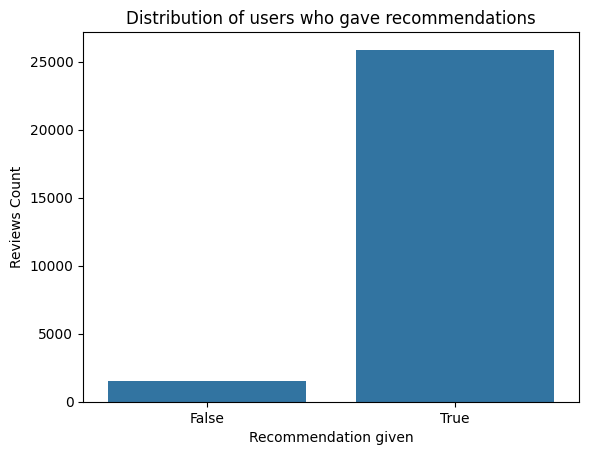

In [26]:
sns.countplot(x = 'reviews_doRecommend', data = prod_reviews).set(title='Distribution of users who gave recommendations', xlabel='Recommendation given', ylabel='Reviews Count')
plt.show()

This is not a useful information for Sentiment analysis. The column will be dropped in the Data Cleaning step.

Group the dataframe by product id and view the user sentiment count

In [27]:
prod_reviews['user_sentiment'] = prod_reviews['user_sentiment'].map({'Positive': 1, 'Negative': 0})

In [28]:
def filter_products(productId, pos=1):
    review_count = prod_reviews[(prod_reviews.id==productId) & (prod_reviews.user_sentiment==pos)]['brand'].count()
    return review_count

In [29]:
prod_reviews_custom =  prod_reviews.groupby('id', as_index=False)['user_sentiment'].count()
prod_reviews_custom["pos_review_count"] =  prod_reviews_custom.id.apply(lambda id: filter_products(id, 1))
prod_reviews_custom["neg_review_count"] =  prod_reviews_custom.id.apply(lambda id: filter_products(id, 0))

In [30]:
prod_reviews_custom.head(15)

,id,user_sentiment,pos_review_count,neg_review_count
0,AV13O1A8GV-KLJ3akUyj,1,1,0
1,AV14LG0R-jtxr-f38QfS,2,2,0
2,AV16khLE-jtxr-f38VFn,27,14,13
3,AV1YGDqsGV-KLJ3adc-O,348,278,70
4,AV1YIch7GV-KLJ3addeG,1,0,1
5,AV1YlENIglJLPUi8IHsX,17,15,2
6,AV1YmBrdGV-KLJ3adewb,18,16,2
7,AV1YmDL9vKc47QAVgr7_,89,82,7
8,AV1Ymf_rglJLPUi8II2v,34,31,3
9,AV1Yn94nvKc47QAVgtst,25,20,5


In [31]:
prod_reviews.user_sentiment.value_counts()

,count
user_sentiment,
1,26632
0,3367


In [32]:
prod_reviews.reviews_rating.value_counts()

,count
reviews_rating,
5,20830
4,6020
1,1384
3,1345
2,420


In [33]:
prod_reviews.pivot_table(index='user_sentiment', columns='reviews_rating', values='reviews_text', aggfunc='count')

reviews_rating,1,2,3,4,5
user_sentiment,,,,,
0,597,140,220,550,1860
1,787,280,1125,5470,18970


Let's visualize this in a plot

<Axes: xlabel='user_sentiment'>

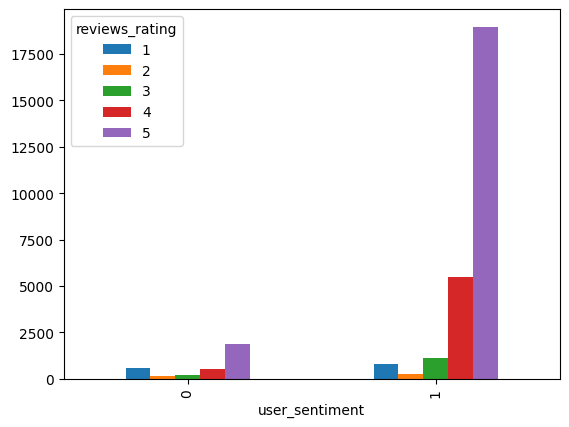

In [34]:
prod_reviews.pivot_table(index='user_sentiment', columns='reviews_rating', values='reviews_text', aggfunc='count').plot(kind='bar')

### Observations:
We have a strange observation in the data. There are 2 cases -
1. For Positive sentiment we have low ratings and
2. For Negative sentiment we have higher ratings as 4 or 5.

This is an anomaly and might affect the further analysis adversely. Let's proceed to Data Cleaning.

In [35]:
print('No. of Unique Manufacturers: ',prod_reviews.manufacturer.nunique())
print('No. of products with manufacturer unknown: ',prod_reviews.manufacturer.isnull().sum())
print('Top 10 manufactures : ', prod_reviews.manufacturer.value_counts().head(10))

No. of Unique Manufacturers:  227
No. of products with manufacturer unknown:  141
Top 10 manufactures :  manufacturer
Clorox                    8546
Test                      3325
AmazonUs/CLOO7            2039
L'oreal Paris             1232
Walt Disney               1142
Burt's Bees                873
SONY CORP                  845
Twentieth Century Fox      757
P&G                        730
Nexxus Beauty Products     693
Name: count, dtype: int64


This column does not provide any significant information for sentiment analysis, it will be dropped in Data Cleaning step.

In [36]:
prod_reviews.reviews_didPurchase.isna().sum()

np.int64(14067)

In [37]:
prod_reviews.reviews_didPurchase.value_counts()

,count
reviews_didPurchase,
False,14498
True,1434


This column does not provide any significant information for sentiment analysis, it will be dropped in Data Cleaning step.

### Data Cleaning

Let's fix the anomaly first.

In [38]:
def alter_sentiment(row):
  if row > 0 and row < 3:
    return '0'
  elif row >= 3:
    return '1'

In [39]:
prod_reviews['user_sentiment'] = prod_reviews['reviews_rating'].apply(alter_sentiment)

In [40]:
prod_reviews.pivot_table(index='user_sentiment', columns='reviews_rating', values='reviews_text', aggfunc='count')

reviews_rating,1,2,3,4,5
user_sentiment,,,,,
0,1384.0,420.0,NaN,NaN,NaN
1,NaN,NaN,1345.0,6020.0,20830.0


In [41]:
prod_reviews.user_sentiment.value_counts()

,count
user_sentiment,
1,28195
0,1804


The columns `review_text` and `review_title` can be combined to one, and then we can drop the original columns

In [42]:
prod_reviews['text_reviews_combined'] = prod_reviews['reviews_text'].fillna('') + ' ' + prod_reviews['reviews_title'].fillna('')
prod_reviews.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,text_reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,1,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,1,Good flavor. This review was collected as part...


There are columns having high number of null-values, viz. `reviews_userCity`, `reviews_userProvince`, `reviews_didPurchase`. Similarly, `reviews_date` and `reviews_doRecommend` is observed to have no impact on Sentiment Analysis. For now, we will drop these columns.

In [43]:
prod_reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,text_reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,1,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,1,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,1,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,0,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,0,My husband bought this gel for us. The gel cau...


In [44]:
prod_reviews_final_data = prod_reviews.drop(['manufacturer',
                                             'reviews_date',
                                             'reviews_didPurchase',
                                             'reviews_doRecommend',
                                             'reviews_text',
                                             'reviews_title',
                                             'reviews_userCity',
                                             'reviews_userProvince',
                                             'reviews_username'],axis=1)

In [45]:
prod_reviews_final_data.head(2)

,id,brand,categories,name,reviews_rating,user_sentiment,text_reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,1,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,1,Good flavor. This review was collected as part...


In [46]:
prod_reviews_final_data.isnull().sum()

,0
id,0
brand,0
categories,0
name,0
reviews_rating,0
user_sentiment,0
text_reviews_combined,0


In [47]:
prod_reviews_final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29999 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     29999 non-null  object
 1   brand                  29999 non-null  object
 2   categories             29999 non-null  object
 3   name                   29999 non-null  object
 4   reviews_rating         29999 non-null  int64 
 5   user_sentiment         29999 non-null  object
 6   text_reviews_combined  29999 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


Except for `reviews_rating`, and `user_sentiment` all other columns need to be converted to 'str' datatype. These two column should be 'int' type. Selecting only those columns which will be helpful for Sentiment analysis.

In [48]:
prod_reviews_final_data[['brand', 'categories', 'name', 'text_reviews_combined']]=prod_reviews_final_data[['brand', 'categories', 'name', 'text_reviews_combined']].astype(str)

In [49]:
prod_reviews_final_data[['user_sentiment', 'reviews_rating']] = prod_reviews_final_data[['user_sentiment', 'reviews_rating']].astype(int)

In [50]:
prod_reviews_final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29999 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     29999 non-null  object
 1   brand                  29999 non-null  object
 2   categories             29999 non-null  object
 3   name                   29999 non-null  object
 4   reviews_rating         29999 non-null  int64 
 5   user_sentiment         29999 non-null  int64 
 6   text_reviews_combined  29999 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.8+ MB


### Text Pre-Processing

In [51]:
lemmatizer = WordNetLemmatizer()

In [52]:
negation_words = {"not", "don't", "no", "nor", "never"}
# Create a custom stopword list by removing the negations
custom_stopwords = stopwords - negation_words

In [53]:
def remove_stopwords(text):
  text = text.lower()
  words = word_tokenize(text)
  return ' '.join([word for word in words if word not in custom_stopwords])

In [54]:
def remove_punctuation(text):
  return re.sub(r'[^\w\s]', '', text)

In [55]:
def lemmatize_text(text):
  words = word_tokenize(text)
  return ' '.join([lemmatizer.lemmatize(word) for word in words])

In [56]:
prod_reviews_final_data['text_reviews_cleaned'] = prod_reviews_final_data['text_reviews_combined'].apply(remove_punctuation)

In [57]:
prod_reviews_final_data['text_reviews_cleaned'] = prod_reviews_final_data['text_reviews_cleaned'].apply(remove_stopwords)

In [58]:
prod_reviews_final_data['text_reviews_cleaned'] = prod_reviews_final_data['text_reviews_cleaned'].apply(lemmatize_text)

In [59]:
# Randomly check 5 rows from the prod_reviews_final_data df for the text_reviews_cleaned column values

pd.set_option('display.max_colwidth', 250)
print(prod_reviews_final_data.sample(5)['text_reviews_cleaned'])
pd.reset_option('display.max_colwidth')

16072                                                                                                                                                    huge fan gloss need moisture balm product delivers look awesome keep lip looking chapped summer look must
27232                                                                                                                                                 movie not good compared first one main character likable put self inflected situation went another direction
28778    avoid cost stuff awful hold hair faux hawk quite wellits not worth disgusting greasy oily feeling leaf behindand will noti repeat others said not wash even used wife highdollar solon shampoo usuallyh ave wash 23 time terrible dont know leave bad ...
20933                                                                                                                                                                                                              salsa love b

In [60]:
prod_reviews_final_data.head(2)

,id,brand,categories,name,reviews_rating,user_sentiment,text_reviews_combined,text_reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,1,i love this album. it's very good. more to the...,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,1,Good flavor. This review was collected as part...,good flavor review collected part promotion good


## Feature Extraction
#### Feature Extraction using TF-IDF - Convert the raw texts to a matrix of TF-IDF features
#### Handle Class imbalance
#### Divide the dataset into train and test data

There are 2 options -
1. CountVectorizer + Tfidftransformer
2. Tfidfvectorizer

Choosing the 2nd as it is an all-in-one functionality : Tokenization(splits words), Count Vectorization and TF-IDF weighting

In [61]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,4))
x_tfidf = tfidf_vectorizer.fit_transform(prod_reviews_final_data['text_reviews_cleaned'])
y_tfidf = prod_reviews_final_data['user_sentiment']
x_tfidf.shape

(29999, 1012323)

In [62]:
save_model(tfidf_vectorizer, 'tfidf_vectorizer')

In [63]:
save_model(prod_reviews_final_data, 'prod_reviews_final_data')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y_tfidf, random_state=42, test_size=0.25)

In [65]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22499, 1012323) (22499,)
Test shapes: (7500, 1012323) (7500,)


In [66]:
prod_reviews_final_data['user_sentiment'].value_counts(normalize=True)

,proportion
user_sentiment,
1,0.939865
0,0.060135


This shows heavy class imbalance in the data. Positive sentiments make up 93% of the data and Negative sentiments make up only 6%

This imbalance will be handled using a technique called SMOTE (Synthetic Minority Oversampling Technique)
This is an oversampling method that generates synthetic samples for the minority class.

In [67]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=25)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({1: 21163, 0: 1336})
After handling imbalance Counter({0: 21163, 1: 21163})


Looking at the record count we can see that both Positive and Negative sentiments have equal number of records now.

All the Data Analysis and Pre-processing is now done, let's proceed to model building.

## Model Building

We will be creating the following three ML models based on performance for predicting the sentiments based on the text and title of the reviews:

1. Logistic Regression
2. Random Forest
3. XGBoost

In [68]:
import torch
import scipy.sparse as sp

class model_building:
  def __init__(self, model_name, X_train, X_test, y_train, y_test):
    self.model_name = model_name
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def train_model(self):
    # Move data to GPU if it's a tensor and GPU is available
    if torch.cuda.is_available() and not isinstance(self.X_train, sp.csr_matrix):
        self.X_train = self.X_train.cuda()
        self.y_train = self.y_train.cuda()

    self.model_name.fit(self.X_train, self.y_train)

    # Move test data to GPU if it's a tensor and GPU is available for prediction
    if torch.cuda.is_available() and not isinstance(self.X_test, sp.csr_matrix):
        X_test_gpu = self.X_test.cuda()
    else:
        X_test_gpu = self.X_test # Use CPU data if not using GPU or if it's a sparse matrix


    # Move predictions to CPU for evaluation
    if torch.cuda.is_available() and not isinstance(self.X_test, sp.csr_matrix):
        return self.model_name.predict(X_test_gpu).cpu()
    else:
        return self.model_name.predict(X_test_gpu)


  def evaluate_model(self, y_pred):
    print("\n")
    print("-"*25)
    self.result_metrics = self.evaluate_metrics(y_pred)
    print("-"*25)
    print("\n")

    print(classification_report(self.y_test, y_pred))
    print("-"*25)
    print("\n")
    self.confusion_matrix(y_pred)
    print("-"*25)
    print("\n")
    # Move data to GPU for ROC curve if it's a tensor and GPU is available
    if torch.cuda.is_available() and not isinstance(self.X_test, sp.csr_matrix):
        RocCurveDisplay.from_estimator(self.model_name, self.X_test.cuda(), self.y_test)
    else:
        RocCurveDisplay.from_estimator(self.model_name, self.X_test, self.y_test)


    return self.result_metrics

  def evaluate_metrics(self, y_pred):
    result_metrics = []
    # Convert y_test and y_pred to integers
    y_test_int = self.y_test.astype(int)
    y_pred_int = y_pred.astype(int)

    accuracy = metrics.accuracy_score(y_test_int, y_pred_int)
    precision = metrics.precision_score(y_test_int, y_pred_int)
    recall = metrics.recall_score(y_test_int, y_pred_int)
    f1_score = metrics.f1_score(y_test_int, y_pred_int)
    roc_auc = metrics.roc_auc_score(y_test_int, y_pred_int)

    print(f"Accuracy  : {accuracy*100:.1f}%")
    print(f"Precision : {precision*100:.1f}%")
    print(f"Recall    : {recall*100:.1f}%")
    print(f"F1 Score  : {f1_score*100:.1f}%")
    print(f"Roc-Auc Score :{roc_auc*100:.1f}%")

    result_metrics.append(accuracy)
    result_metrics.append(precision)
    result_metrics.append(recall)
    result_metrics.append(f1_score)
    result_metrics.append(roc_auc)

    return result_metrics

  def confusion_matrix(self, y_pred):
    cm = metrics.confusion_matrix(self.y_test.astype(int), y_pred.astype(int))
    self.plot_confusion_matrix(cm, ['0','1'])  # Class 0:Negative, 1:Positive

  def plot_confusion_matrix(self, cm, labels):
    plt.figure(figsize=(4, 4))
    plt.title("Confusion Matrix")
    sns.set(color_codes=True)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, cmap="Blues", fmt=".2%")

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(ylabel="True Values", xlabel="Predicted Values")
    plt.show()

  def classification_report(self, y_pred):
    print(classification_report(self.y_test, y_pred))

### 1. Logistic Regression

Base Model

In [69]:
logreg = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")

In [70]:
lr_model = model_building(logreg, X_train_sm, X_test, y_train_sm, y_test)



-------------------------
Accuracy  : 97.0%
Precision : 97.9%
Recall    : 99.0%
F1 Score  : 98.4%
Roc-Auc Score :83.2%
-------------------------


              precision    recall  f1-score   support

           0       0.81      0.68      0.74       468
           1       0.98      0.99      0.98      7032

    accuracy                           0.97      7500
   macro avg       0.90      0.83      0.86      7500
weighted avg       0.97      0.97      0.97      7500

-------------------------




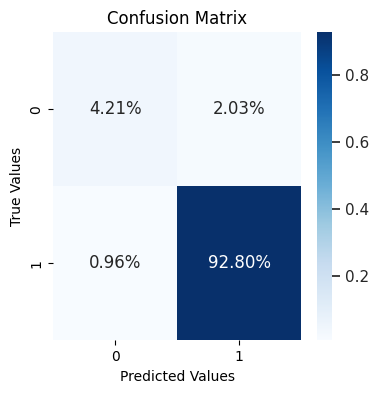

-------------------------




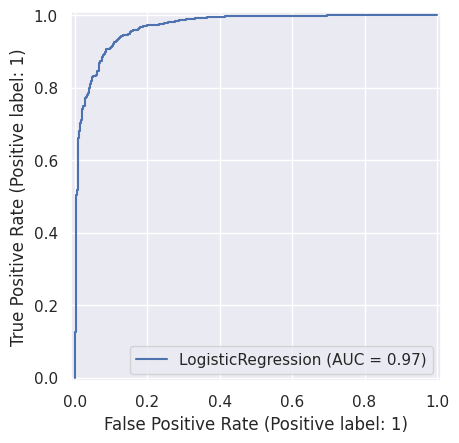

In [71]:
# Train and Predict the Test Labels
y_pred  = lr_model.train_model()
lr_metrics = lr_model.evaluate_model(y_pred)

In [72]:
df_lr_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'Logistic Regression Base Model': lr_metrics},
                             columns = ['Metrics', 'Logistic Regression Base Model']
                             )
df_lr_metrics

,Metrics,Logistic Regression Base Model
0,Accuracy,0.970133
1,Sensitivity/Recall,0.978628
2,Specificity,0.989761
3,Precision,0.984163
4,F1 Score,0.832487


#### Save the model as pickle files

In [73]:
save_model(logreg, 'lr_model')

HyperParameter Tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'C': 100, 'solver': 'liblinear'}
Best F1-score found:  0.9986274199119933


-------------------------
Accuracy  : 97.4%
Precision : 97.4%
Recall    : 99.8%
F1 Score  : 98.6%
Roc-Auc Score :80.3%
-------------------------


              precision    recall  f1-score   support

           0       0.96      0.61      0.74       468
           1       0.97      1.00      0.99      7032

    accuracy                           0.97      7500
   macro avg       0.97      0.80      0.86      7500
weighted avg       0.97      0.97      0.97      7500

-------------------------




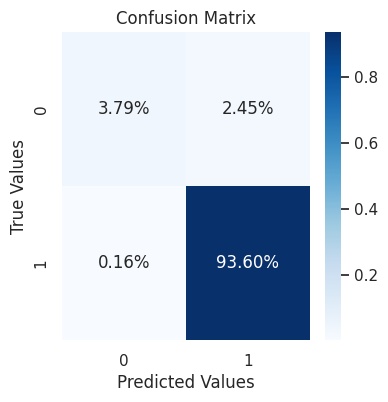

-------------------------




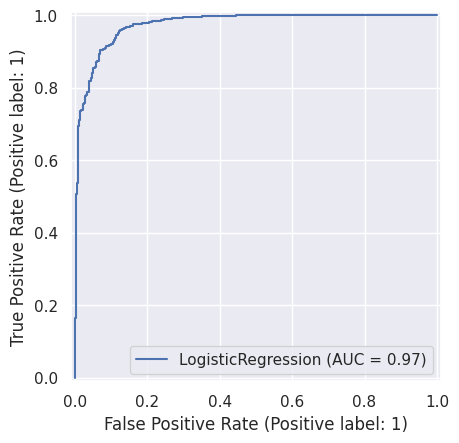

In [74]:
# Define the parameter grid for Logistic Regression
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit the grid search to the training data
logreg_hpt.fit(X_train_sm, y_train_sm)

# Print the best parameters and the corresponding F1-score
print("Best parameters found: ", logreg_hpt.best_params_)
print("Best F1-score found: ", logreg_hpt.best_score_)

# Get the best model from the grid search
best_logreg_model = logreg_hpt.best_estimator_

# Evaluate the best model on the test set
y_pred_tuned = best_logreg_model.predict(X_test)
lr_tuned_metrics = model_building(best_logreg_model, X_train_sm, X_test, y_train_sm, y_test).evaluate_model(y_pred_tuned)


In [75]:
dict_lr_bst_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                               'LR Base Model': lr_metrics,
                               'LR Tuned Model': lr_tuned_metrics}

df_lr_bst_metrics = pd.DataFrame(dict_lr_bst_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model'])
df_lr_bst_metrics

,Metrics,LR Base Model,LR Tuned Model
0,Accuracy,0.970133,0.973867
1,Sensitivity/Recall,0.978628,0.974459
2,Specificity,0.989761,0.998294
3,Precision,0.984163,0.986232
4,F1 Score,0.832487,0.802566


In [76]:
save_model(logreg_hpt, 'logreg_hpt')

Interpretation
Tuned Model improves accuracy, specificity, and precision, which means:

- It's more confident and correct overall.

- It's better at identifying negatives (Specificity ↑).

- It's slightly more precise, meaning fewer false positives.

However, Base Model has better recall and higher F1 Score, meaning:

- It catches more true positives (good for imbalanced data).

- F1 Score suggests a better balance of precision and recall.

In this case, we want High Precision (don’t recommend bad products), Good Recall (catch most good ones) and Balanced F1 Score.

Since the F1 score dropped in the tuned model, and recall also dropped slightly, **we prefer the Base Model** for comparison with other model performance later.

### 2. Random Forest Classifier

In [77]:
rf = RandomForestClassifier(random_state=42)

In [78]:
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

In [79]:
rf_model = model_building(rf, X_train_sm, X_test, y_train_sm, y_test)



-------------------------
Accuracy  : 96.7%
Precision : 96.6%
Recall    : 100.0%
F1 Score  : 98.3%
Roc-Auc Score :73.7%
-------------------------


              precision    recall  f1-score   support

           0       0.99      0.47      0.64       468
           1       0.97      1.00      0.98      7032

    accuracy                           0.97      7500
   macro avg       0.98      0.74      0.81      7500
weighted avg       0.97      0.97      0.96      7500

-------------------------




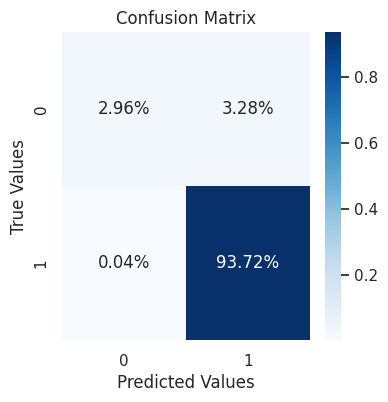

-------------------------




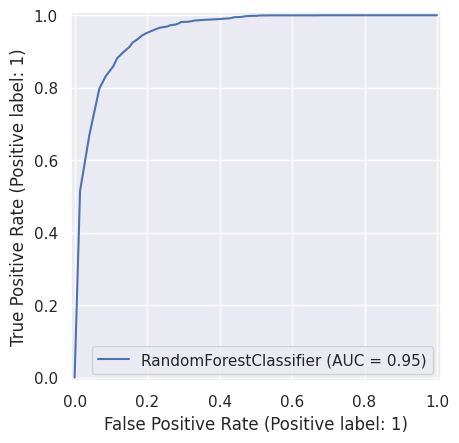

In [80]:
# Train and Predict the Test Labels
y_pred_rf  = rf_model.train_model()
rf_metrics = rf_model.evaluate_model(y_pred_rf)

Recall is 100% but other parameters are not improved. Let's try Hyper-parameter tuning of this model.

In [81]:
save_model(rf, 'rf_model')

HyperParameter Tuning of Random Forest classifier

In [82]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [83]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [84]:
# Print the best parameters
print("Best parameters found: ", rf_hpt.best_params_)

Best parameters found:  {'n_estimators': np.int64(410), 'min_samples_split': np.int64(330), 'min_samples_leaf': np.int64(10), 'max_depth': np.int64(35)}




-------------------------
Accuracy  : 95.5%
Precision : 96.9%
Recall    : 98.4%
F1 Score  : 97.6%
Roc-Auc Score :75.5%
-------------------------


              precision    recall  f1-score   support

           0       0.69      0.53      0.59       468
           1       0.97      0.98      0.98      7032

    accuracy                           0.96      7500
   macro avg       0.83      0.75      0.79      7500
weighted avg       0.95      0.96      0.95      7500

-------------------------




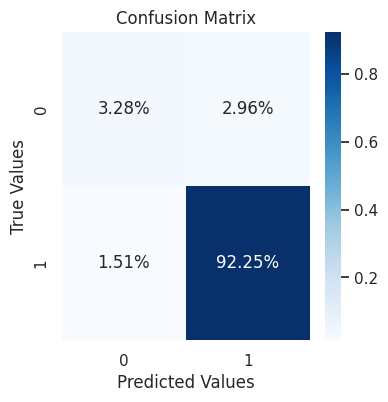

-------------------------




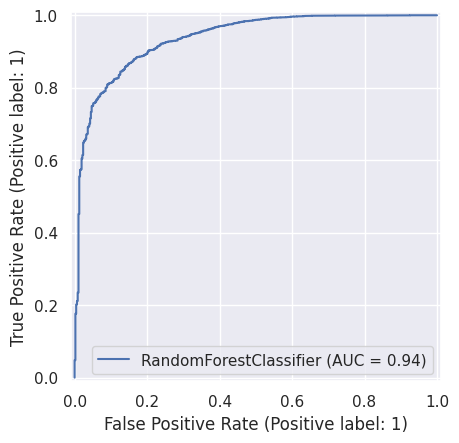

In [85]:
# Get the best model from the grid search
best_rf_model = rf_hpt.best_estimator_

# Evaluate the best model on the test set
y_pred_rf_best = best_rf_model.predict(X_test)
rf_tuned_metrics = model_building(best_rf_model, X_train_sm, X_test, y_train_sm, y_test).evaluate_model(y_pred_rf_best)

In [86]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [87]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [88]:
# Print the best parameters
print("Best parameters found: ", rf_hpt.best_params_)

Best parameters found:  {'n_estimators': np.int64(510), 'min_samples_split': np.int64(360), 'min_samples_leaf': np.int64(5), 'max_depth': np.int64(35)}




-------------------------
Accuracy  : 95.7%
Precision : 96.9%
Recall    : 98.6%
F1 Score  : 97.7%
Roc-Auc Score :75.3%
-------------------------


              precision    recall  f1-score   support

           0       0.71      0.52      0.60       468
           1       0.97      0.99      0.98      7032

    accuracy                           0.96      7500
   macro avg       0.84      0.75      0.79      7500
weighted avg       0.95      0.96      0.95      7500

-------------------------




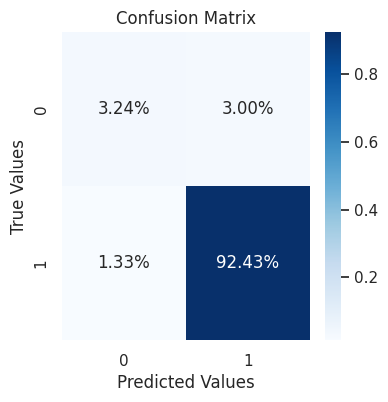

-------------------------




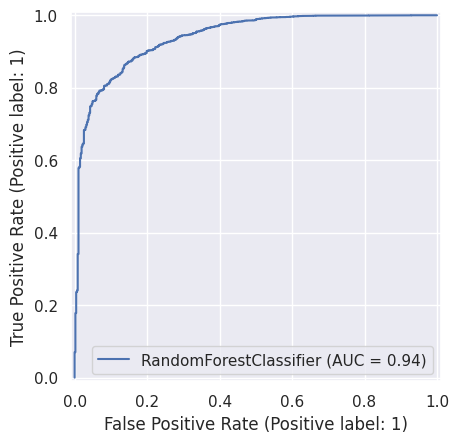

In [89]:
# Get the best model from the grid search
best_rf_model = rf_hpt.best_estimator_

# Evaluate the best model on the test set
y_pred_rf_best = best_rf_model.predict(X_test)
rf_tuned_metrics = model_building(best_rf_model, X_train_sm, X_test, y_train_sm, y_test).evaluate_model(y_pred_rf_best)

Not much improvement is seen than the base Random Forest model. Let's try using Grid Search

In [90]:
rf_grid = {"n_estimators": [100, 150],
           "max_depth": [3, 5, 10, 50],
           "min_samples_leaf": [10, 20]}

In [91]:
rf_grid_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_grid_hpt.fit(X_train_sm, y_train_sm);

Fitting 4 folds for each of 16 candidates, totalling 64 fits


Best parameters found:  {'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 100}


-------------------------
Accuracy  : 95.5%
Precision : 97.0%
Recall    : 98.2%
F1 Score  : 97.6%
Roc-Auc Score :76.5%
-------------------------


              precision    recall  f1-score   support

           0       0.67      0.55      0.60       468
           1       0.97      0.98      0.98      7032

    accuracy                           0.96      7500
   macro avg       0.82      0.76      0.79      7500
weighted avg       0.95      0.96      0.95      7500

-------------------------




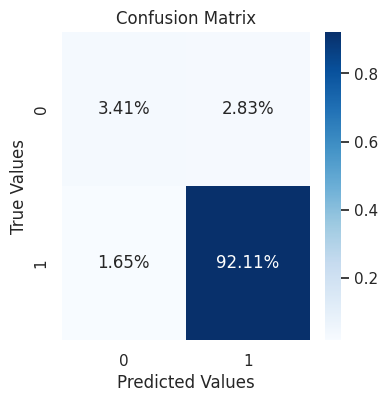

-------------------------




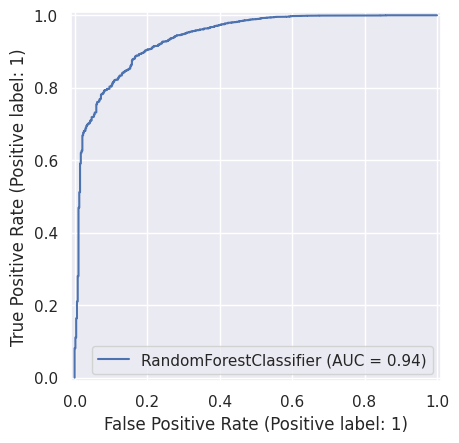

In [92]:
# Print the best parameters
print("Best parameters found: ", rf_grid_hpt.best_params_)
# Get the best model from the grid search
best_rf_grid_model = rf_grid_hpt.best_estimator_

# Evaluate the best model on the test set
y_pred_rf_grid_best = best_rf_grid_model.predict(X_test)
rf_grid_tuned_metrics = model_building(best_rf_grid_model, X_train_sm, X_test, y_train_sm, y_test).evaluate_model(y_pred_rf_grid_best)

Not better than the Base Logistic model performance.

### 3. XGBoost Classifier

In [93]:
xbg_clf = xgb.XGBClassifier(random_state=42)
xbg_clf.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [94]:
xgb_clf_model = model_building(xbg_clf, X_train_sm, X_test, y_train_sm, y_test)



-------------------------
Accuracy  : 96.3%
Precision : 97.8%
Recall    : 98.2%
F1 Score  : 98.0%
Roc-Auc Score :82.9%
-------------------------


              precision    recall  f1-score   support

           0       0.71      0.68      0.69       468
           1       0.98      0.98      0.98      7032

    accuracy                           0.96      7500
   macro avg       0.85      0.83      0.84      7500
weighted avg       0.96      0.96      0.96      7500

-------------------------




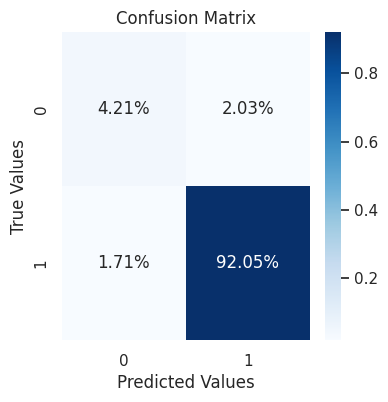

-------------------------




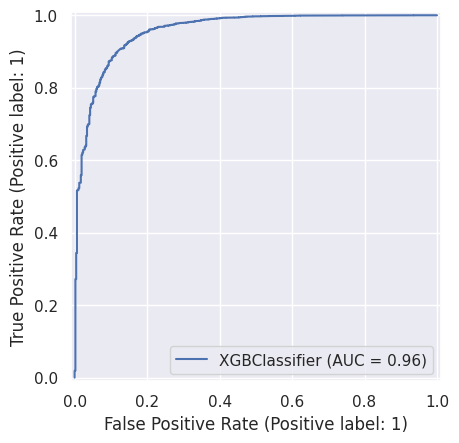

In [95]:
# Train and Predict the Test Labels
y_pred_xgbclf  = xgb_clf_model.train_model()
xgb_clf_metrics = xgb_clf_model.evaluate_model(y_pred_xgbclf)

HyperParameter Tuning of XGBoost Classifier with Grid Search

In [98]:
# Fine tuning with Grid Search CV
xg_grid = {"learning_rate": [0.1, 0.01],
           "max_depth": [3, 5]
           }

In [99]:
xgb_hpt = GridSearchCV(xgb.XGBClassifier(random_state=42),
                                param_grid=xg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=1, # Reduced the number of parallel jobs
                                scoring='f1')

# Fit random hyperparameter search model
xgb_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5}


-------------------------
Accuracy  : 94.6%
Precision : 97.9%
Recall    : 96.3%
F1 Score  : 97.1%
Roc-Auc Score :82.9%
-------------------------


              precision    recall  f1-score   support

           0       0.56      0.69      0.62       468
           1       0.98      0.96      0.97      7032

    accuracy                           0.95      7500
   macro avg       0.77      0.83      0.79      7500
weighted avg       0.95      0.95      0.95      7500

-------------------------




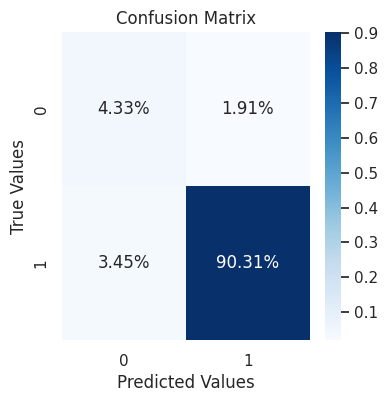

-------------------------




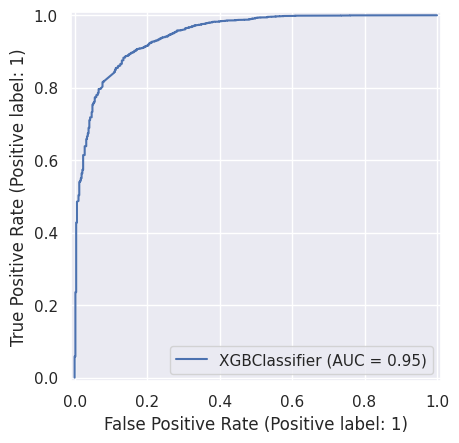

In [100]:
# Print the best parameters
print("Best parameters found: ", xgb_hpt.best_params_)
# Get the best model from the grid search
best_xgb_hpt_model = xgb_hpt.best_estimator_

# Evaluate the best model on the test set
y_pred_xgb_grid_best = best_xgb_hpt_model.predict(X_test)
xgb_grid_tuned_metrics = model_building(best_xgb_hpt_model, X_train_sm, X_test, y_train_sm, y_test).evaluate_model(y_pred_xgb_grid_best)

In [101]:
save_model(xgb_hpt, 'xgb_hpt')

### 4. Naive Bayes

In [102]:
mnb = MultinomialNB(alpha=1.0)
mnb_model = model_building(mnb, X_train, X_test, y_train, y_test)




-------------------------
Accuracy  : 94.1%
Precision : 94.0%
Recall    : 100.0%
F1 Score  : 96.9%
Roc-Auc Score :52.4%
-------------------------


              precision    recall  f1-score   support

           0       1.00      0.05      0.09       468
           1       0.94      1.00      0.97      7032

    accuracy                           0.94      7500
   macro avg       0.97      0.52      0.53      7500
weighted avg       0.94      0.94      0.91      7500

-------------------------




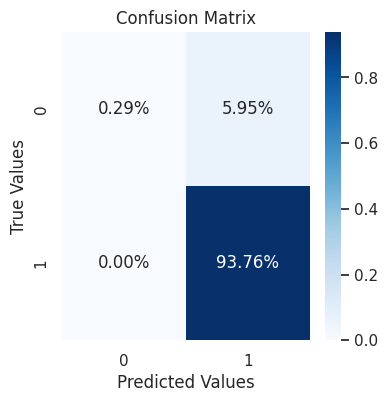

-------------------------




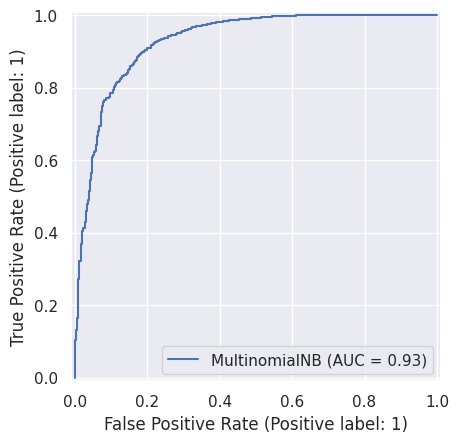

In [103]:
y_pred_mnb = mnb_model.train_model()
mnb_metrics = mnb_model.evaluate_model(y_pred_mnb)

HyperParameter Tuning on Naive Bayes Model

In [104]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0]}
mnb_grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5)

In [105]:
mnb_grid.fit(X_train_sm, y_train_sm);

Best parameters found:  {'alpha': 0.01}


-------------------------
Accuracy  : 97.1%
Precision : 97.3%
Recall    : 99.7%
F1 Score  : 98.5%
Roc-Auc Score :79.0%
-------------------------


              precision    recall  f1-score   support

           0       0.93      0.58      0.72       468
           1       0.97      1.00      0.98      7032

    accuracy                           0.97      7500
   macro avg       0.95      0.79      0.85      7500
weighted avg       0.97      0.97      0.97      7500

-------------------------




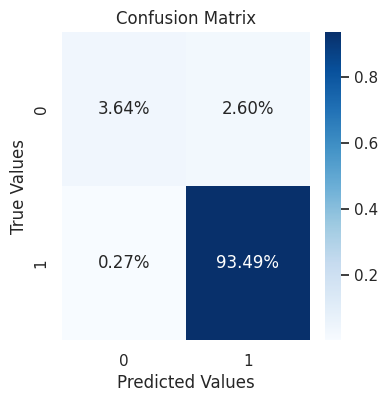

-------------------------




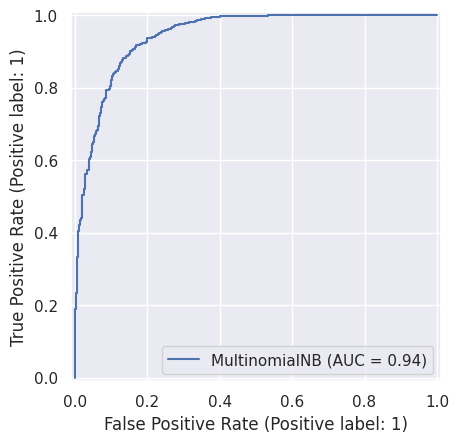

In [106]:
# Print the best parameters
print("Best parameters found: ", mnb_grid.best_params_)
# Get the best model from the grid search
best_mnb_model = mnb_grid.best_estimator_

# Evaluate the best model on the test set
y_pred_xgb_grid_best = best_mnb_model.predict(X_test)
mnb_grid_tuned_metrics = model_building(best_mnb_model, X_train_sm, X_test, y_train_sm, y_test).evaluate_model(y_pred_xgb_grid_best)

In [107]:
save_model(mnb_grid, 'mnb_grid')

### Model Comparison and Conclusion

In [108]:
metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','ROC-Auc Score'],
        'Logistic Regression': lr_metrics,
        'Random Forest': rf_metrics,
        'XG Boost': xgb_grid_tuned_metrics,
        'Naive Bayes': mnb_grid_tuned_metrics,
        }

metrics_df = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Random Forest', 'XG Boost', 'Naive Bayes'] )

metrics_df

,Metric,Logistic Regression,Random Forest,XG Boost,Naive Bayes
0,Accuracy,0.970133,0.966800,0.946400,0.971333
1,Precision,0.978628,0.966186,0.979323,0.972943
2,Recall,0.989761,0.999573,0.963168,0.997156
3,F1Score,0.984163,0.982596,0.971179,0.984901
4,ROC-Auc Score,0.832487,0.736966,0.828806,0.790245


Looking at the model evaluation metrics and focusing on ROC-AUC Score, we can conclude that the Base Logistic Regression Model is the best model out of all of them.

In [109]:
save_model(logreg, 'final_model')

In [110]:
log_reg = pickle.load(open(folderpath+'final_model.pkl', 'rb'))
prod_reviews_final_data = pickle.load(open(folderpath+'pickle/prod_reviews_final_data.pkl', 'rb'))

## Recommendation System

There are different ways to build recommendation systems. Broad categories are Content-Based Filtering and Collaborative Filtering.
We will be building 2 types of Collaborative Filtering to build the recommendation systems -
1. User-User Based Filtering (UBCF) and
2. Item-Item Based Filtering (IBCF)
After evaluating both, the best will be selected.
Once the best-suited recommendation system is finalized, the next task will be to recommend 20 products that a user is most likely to purchase based on the ratings.

In [111]:
recomm_df = pd.read_csv(filepath)
recomm_df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


### 1. User-User Based Filtering (UBCF)

In [112]:
recomm_df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


Selecting only the required columns for further processing

In [113]:
recomm_df = recomm_df[['id', 'name', 'reviews_rating', 'reviews_username']]

In [114]:
null_count = recomm_df.isnull().sum()
null_perct = recomm_df.isnull().sum()/recomm_df.shape[0] * 100

In [115]:
temp_df = pd.concat([null_count, null_perct], axis=1)
temp_df.columns = ['null_count', 'null_perct']
temp_df.sort_values(by='null_count', ascending=False)

,null_count,null_perct
reviews_username,63,0.21
id,0,0.00
name,0,0.00
reviews_rating,0,0.00


In [116]:
recomm_df.dropna(subset=['reviews_username'], inplace=True)
recomm_df.reviews_username.nunique()

24914

In [117]:
recomm_df.shape

(29937, 4)

In [118]:
recomm_df.isnull().sum()

,0
id,0
name,0
reviews_rating,0
reviews_username,0


In [119]:
recomm_df.columns=['prod_id', 'Prod_name', 'rating', 'user']

In [120]:
recomm_df.rating.value_counts()

,count
rating,
5,20792
4,6010
1,1373
3,1344
2,418


#### Train-Test Split

In [121]:
train, test = train_test_split(recomm_df, test_size=0.3, random_state=42)
print(train.shape)
print(test.shape)

(20955, 4)
(8982, 4)


In [122]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
train_pivot = train.pivot_table(
    index = 'user',
    columns = 'prod_id',
    values = 'rating'
).fillna(0)
train_pivot.head()

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating dummy train & dummy test dataset
These datasets will be used for prediction
- Dummy train will be used later for prediction of the products which have not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [123]:
dummy_train = train.copy()
dummy_train.head(1)

,prod_id,Prod_name,rating,user
962,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,5,brittney w


In [124]:
# The products not rated by user is marked as 1 for prediction.
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [125]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='user',
    columns='prod_id',
    values='rating'
).fillna(1)

In [126]:
dummy_train.head()

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case]

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



#### Use Similarity Matrix
##### Using Cosine Similarity

In [127]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(train_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [128]:
user_correlation.shape

(18275, 18275)

##### Using Adjusted Cosine Similarity
Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [129]:
#Create a user-product matrix
train_pivot = train.pivot_table(
    index='user',
    columns='prod_id',
    values='rating'
)

In [130]:
train_pivot.head()

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the rating of the product for each user around 0 mean

In [131]:
mean = np.nanmean(train_pivot, axis=1)
df_subtracted = (train_pivot.T-mean).T

In [132]:
df_subtracted.head()

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### User-User Prediction

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [134]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [135]:
user_predicted_ratings = np.dot(user_correlation, train_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 1.88982237,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [136]:
user_predicted_ratings.shape

(18275, 256)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [137]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head(10)

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596262,0.0,0.0,0.0,0.0,2.581989,1.018079,...,1.666667,0.188982,0.0,0.0,0.0,0.0,0.0,1.465257,1.889822,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
06stidriver,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
08dallas,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
09mommy11,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1.11E+24,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [138]:
save_model(user_final_rating, 'user_final_rating')

### Finding the Top 20 products that a user is most likely to purchase based on the ratings (user-user based recommendation)

In [139]:
# Take the user ID as input. -- Enter 'askme' as the user name
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: zitro
zitro


In [140]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpfPaoqLJeJML435Xk9,24.407070
1,AVpf0eb2LJeJML43EVSt,14.058342
2,AVpf3VOfilAPnD_xjpun,13.943611
3,AVpfRTh1ilAPnD_xYic2,13.289778
4,AVpfJP1C1cnluZ0-e3Xy,11.689675
5,AVpf2tw1ilAPnD_xjflC,11.339146
6,AVpfPnrU1cnluZ0-g9rL,6.465930
7,AVpf385g1cnluZ0-s0_t,6.345689
8,AVpf5olc1cnluZ0-tPrO,6.140757
9,AVpf7LysilAPnD_xkm9G,5.830022


### Evaluation for user-user recommendation system
Evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [141]:
# Find out the common users of test and train dataset.
common = test[test.user.isin(train.user)]
common.shape

(2051, 4)

In [142]:
common.head()

,prod_id,Prod_name,rating,user
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318
23320,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,3,countprice
21505,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,farbar
29216,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,4,baronesscountess


In [143]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='user', columns='prod_id', values='rating')
common_user_based_matrix.head(1)

prod_id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
user,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
df_subtracted.head(1)

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
user_correlation_df['user'] = df_subtracted.index
user_correlation_df.set_index('user',inplace=True)
user_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
user,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
common.head(1)

,prod_id,Prod_name,rating,user
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica


In [148]:
list_name = common.user.to_list()

In [149]:
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1693, 18275)

In [150]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [151]:
user_correlation_df_3 = user_correlation_df_2.T

In [152]:
user_correlation_df_3.head()

,1234,1234567,123charlie,1943,1witch,4 rooms 1 dog lotsa fur,85lisa,a hutch,aac06002,aalyah,...,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
user,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
user_correlation_df_3.shape

(1693, 1693)

In [154]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [155]:
common.head(1)

,prod_id,Prod_name,rating,user
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica


In [156]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='prod_id', values='rating').fillna(0)
dummy_test.shape

(1693, 140)

In [157]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [158]:
common_user_predicted_ratings.head(2)

prod_id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
user,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
common_user_predicted_ratings.shape

(1693, 140)

Calculating the RMSE for only the products rated by user.
For RMSE, normalising the rating to (1,5) range.

In [160]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [161]:
common_ = common.pivot_table(index='user', columns='prod_id', values='rating')

In [162]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

314

In [163]:
rmse_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user)

2.551419404666111


### Item Based Similarity
Normalize the rating around the mean for different product ID by taking the transpose of the rating matrix. In the user based similarity, we had taken mean for each user instead of each product.

In [164]:
train, test = train_test_split(recomm_df, test_size=0.3, random_state=42)
print(train.shape)
print(test.shape)

(20955, 4)
(8982, 4)


In [165]:
train_pivot_rec = train.pivot_table(
    index='user',
    columns='prod_id',
    values='rating'
).T
train_pivot_rec.head()

user,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
prod_id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the rating of the product for each item around 0 mean

In [166]:
mean = np.nanmean(train_pivot_rec, axis=1)
df_subtracted = (train_pivot_rec.T-mean).T

In [167]:
df_subtracted.head()

user,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
prod_id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [168]:
from sklearn.metrics.pairwise import pairwise_distances

In [169]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### Item-Item Prediction

Doing the prediction for the items which are positively related with other items, and not the items which are negatively related as we are interested in the items which are more similar to the current items. So, ignoring the correlation for values less than 0.

In [170]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [171]:
item_predicted_ratings = np.dot((train_pivot_rec.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00603917, 0.06485571,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0094556 ],
       [0.        , 0.        , 0.        , ..., 0.00781596, 0.10809285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756448]])

In [172]:
item_predicted_ratings.shape

(18275, 256)

In [173]:
dummy_train.shape

(18275, 256)

Filtering the rating only for the products not rated by the user for recommendation

In [174]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

prod_id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.006042,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.020509,0.006039,0.064856,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.097645,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.162741,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.130193,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000082,0.0,0.0,0.0,0.001244,0.002197,0.001808,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.006084,0.000000,0.000000,0.009456


In [175]:
save_model(item_final_rating, 'item_final_rating')

### Finding the Top 20 products that a user is most likely to purchase based on the ratings (item-item based recommendation)

In [176]:
# Take the user ID as input. -- Enter 'askme' as the user name
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: zitro
zitro


In [177]:
top20_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpfJcHuLJeJML433ZrY,0.260804
1,AVpfE7puilAPnD_xUcCW,0.235104
2,AVpfQtEm1cnluZ0-hUpe,0.136935
3,AVpfv4TlilAPnD_xhjNS,0.086474
4,AVpf0thK1cnluZ0-r8vR,0.084997
5,AVpfbraG1cnluZ0-kqnn,0.074337
6,AVpe9W4D1cnluZ0-avf0,0.066159
7,AVpfPx6V1cnluZ0-hA5y,0.065358
8,AVpe6FfKilAPnD_xQmHi,0.048240
9,AVpfBrUZilAPnD_xTUly,0.044295


### Evaluation for item-item recommendation system
Evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

We already have the usernames, which exist in both - test and train datasets

In [178]:
test.columns

Index(['prod_id', 'Prod_name', 'rating', 'user'], dtype='object')

In [179]:
common = test[test.prod_id.isin(train.prod_id)]
common.shape

(8966, 4)

In [180]:
common.head(2)

,prod_id,Prod_name,rating,user
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00


In [181]:
common_item_based_matrix = common.pivot_table(index='user', columns='prod_id', values='rating').T

In [182]:
common_item_based_matrix.shape

(195, 8318)

In [183]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
item_correlation_df['prod_id'] = df_subtracted.index
item_correlation_df.set_index('prod_id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
prod_id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
list_name = common.prod_id.tolist()

In [186]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [187]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [188]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
prod_id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.108098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.45559849e-03]])

In [190]:
common_item_predicted_ratings.shape

(195, 8318)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [191]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='prod_id', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [192]:
common_ = common.pivot_table(index='user', columns='prod_id', values='rating').T

In [193]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [194]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [195]:
rmse_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item)

3.5497841991528967


### Best-suited Recommendation System

To get the best recommendation model, we will use RMSE (Root Mean Square Error) scores for both user-user and item-item based recommendation systems and do a comparison of the values.
The recommendation model with the least RMSE will be selected as the best recommendation model.

In [196]:
if rmse_user < rmse_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


As per the Problem Statement, once we get the best-suited recommendation system, the next task is to recommend 20 products that a user is most likely to purchase based on the ratings.

In [197]:
user_input = 'joshua'

In [198]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpf3VOfilAPnD_xjpun,5.082457
1,AVpfPaoqLJeJML435Xk9,4.405177
2,AVpe41TqilAPnD_xQH3d,3.368371
3,AVpfAgSp1cnluZ0-b2-K,3.077287
4,AVpfDA6wilAPnD_xTxdg,3.077287
5,AVpf0eb2LJeJML43EVSt,2.406789
6,AVpfM_ytilAPnD_xXIJb,1.646811
7,AVpfov9TLJeJML43A7B0,0.896095
8,AVpfPnrU1cnluZ0-g9rL,0.888336
9,AVpe59io1cnluZ0-ZgDU,0.711058


In [202]:
tfidf_vectorizer = pickle.load(open(folderpath+'pickle/tfidf_vectorizer.pkl', 'rb'))
final_model = pickle.load(open(folderpath+'pickle/final_model.pkl', 'rb'))

Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model. Similar method would be used in `model.py`

In [203]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = prod_reviews_final_data[prod_reviews_final_data.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["text_reviews_combined"].values.astype(str))
        temp["predicted_sentiment"]= final_model.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [204]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
3,Cars Toon: Mater's Tall Tales,34,34,34,100.00
7,Disney174 Jake And The Neverland Pirates 4 Pie...,1,1,1,100.00
6,Craft Punch Giga Scallop Circle 45 24687534 To...,1,1,1,100.00
5,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.00
16,Pink Friday: Roman Reloaded Re-Up (w/dvd),1,1,1,100.00
17,Solo Foods Almond Paste,5,5,5,100.00
13,Meguiar's Deep Crystal Car Wash 64-Oz.,20,20,20,100.00
9,"Heinz Tomato Ketchup, 38oz",1,1,1,100.00
12,Lundberg Organic Cinnamon Toast Rice Cakes,2,2,2,100.00
15,"Pantene Color Preserve Volume Shampoo, 25.4oz",18,17,18,94.44


In [205]:
get_sentiment_recommendations("08dallas")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
3,Cars Toon: Mater's Tall Tales,34,34,34,100.0
7,Disney174 Jake And The Neverland Pirates 4 Pie...,1,1,1,100.0
6,Craft Punch Giga Scallop Circle 45 24687534 To...,1,1,1,100.0
5,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.0
16,Pink Friday: Roman Reloaded Re-Up (w/dvd),1,1,1,100.0


In [206]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("xyz12")

User name xyz12 doesn't exist


In [207]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will recommend"])
y_pred_sample = logreg.predict(X_sample)
y_pred_sample

array([1])

In [208]:
X_sample = tfidf_vectorizer.transform(["Worst product, quality is poor"])
y_pred_sample = logreg.predict(X_sample)
y_pred_sample

array([0])